In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')#

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import copy

from sklearn.metrics import confusion_matrix,roc_auc_score, cohen_kappa_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from pdb import set_trace


## define the hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size=5000
max_epoch=200
embed_dim=300
num_classes=160

import pandas as pd
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install bcolz
import bcolz

In [ ]:
glove_path = "/content/drive/My Drive"

words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.300.dat', mode='w')

with open(f'{glove_path}/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float64)

        vectors.append(vect)
    print(idx)
    
vectors = bcolz.carray(vectors[1:].reshape((400001, 300)), rootdir=f'{glove_path}/6B.300.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.300_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.300_idx.pkl', 'wb'))

400001


In [ ]:
vectors = bcolz.open(f'6B.300.dat')[:]
words = pickle.load(open(f'6B.300_words.pkl', 'rb'))
word2idx = pickle.load(open(f'6B.300_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
glove['data']

array([-5.3399e-01, -4.6982e-02,  3.6667e-01,  4.4368e-02, -6.7474e-02,
       -1.0334e-01, -1.3885e-02, -2.1762e-01,  3.2768e-01, -2.7232e+00,
        4.1765e-02, -4.7828e-02,  6.5071e-01, -2.2854e-01, -1.8066e-02,
       -1.3962e-01,  1.3456e-01, -3.6618e-01,  2.5928e-01, -3.9790e-01,
        6.2244e-02, -1.7790e-01,  5.6441e-01,  2.1030e-01,  4.0553e-02,
        8.5501e-02,  2.1529e-02,  4.6933e-01, -2.6026e-02,  4.1781e-01,
        3.3584e-02,  3.5580e-01, -1.2508e-01,  4.1793e-02, -4.6979e-01,
        1.4658e-01,  6.3600e-02,  1.2547e-01,  1.2069e-01,  2.3968e-02,
       -5.7722e-01,  2.7451e-01,  2.6450e-01,  4.7098e-01, -2.5820e-01,
        8.9575e-02, -4.9339e-01, -2.2443e-01, -3.2279e-01,  1.7483e-01,
        6.9591e-01,  1.1779e-01, -2.2283e-01, -3.9215e-02, -1.5047e-01,
       -2.2251e-01,  9.4307e-02, -3.1800e-01, -6.7965e-01,  5.3228e-01,
       -8.9968e-01,  6.2420e-01,  7.5829e-01,  1.9272e-01, -9.0298e-02,
        6.8675e-02,  1.9469e-03,  1.4453e-02,  4.6447e-01,  6.85

In [ ]:
df = pd.read_csv('high_tech_cleaned_0410.csv')
#-- load clean lines

clean_jd = df['jd_cleaned']

df_lines=[]
for line in clean_jd:
    
    df_lines.append(line)



clean_lines=[]
for line in df_lines:
  pattern=re.compile(r'[a-z]+')
  line=line.lower()
  match = pattern.findall(line)
  new_line=' '.join(match)
  clean_lines.append(new_line)



from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5,  min_df=3, stop_words='english')

X=vectorizer.fit_transform(clean_lines)

#X.todense()
print(X.shape)
print()
feature=vectorizer.get_feature_names()
with open('tf_idf.p','wb') as f:
  pickle.dump(X,f)
with open('feature','wb') as f:
  pickle.dump(feature,f)
  print('down')

    
feature_dict={words:i for i, words in enumerate(feature)}

with open('feature_dict.p','wb') as f:
  pickle.dump(feature_dict,f)




#--  how to create the json file of next steps

import json
#-- filter the selected feature, from words  to index

#-- create the empty set
result={}
tier1_set=set()
tier1to2_dict={}
tier2_set=set()


for _,tier2,tier1,_,_,_,_,_,_,_,jd,_ in np.array(df):
    
    
    
    pattern=re.compile(r'[a-z]+')
    match = pattern.findall(jd)
    jd=' '.join(match)

    
    
    
    ## record some basic information
    tier1_set.add(tier1)
    tier2_set.add(tier2)
    if tier1 not in tier1to2_dict:
        tier1to2_dict[tier1]=set()
        tier1to2_dict[tier1].add(tier2)
    else:
        tier1to2_dict[tier1].add(tier2)

    
    ## filter words not in the feature
    new_jd=[]
    for word in jd.split(' '):
        if word in feature_dict:
            new_jd.append(feature_dict[word])
    if len(new_jd)==0:
        continue
    if tier1 not in result:
        result[tier1]={}
        result[tier1]['num']=1
        result[tier1]['jds']=[new_jd]
    else:
        result[tier1]['num'] +=1
        result[tier1]['jds'].append(new_jd)

with open('tier1to2_dict.p','wb') as f:
    pickle.dump(tier1to2_dict,f)
with open('tier1_jds.json','w') as f:
    json.dump(result,f)
    
with open('tier1_jds.txt','w') as f:
    json.dump(result,f)
    
print(len(tier1_set))
print(len(tier2_set))
print(len(result))






#-- tier1 dataset and tier2 dataset

(23201, 23458)

down
47
295
47


In [ ]:


'''
map_dict={}


for _,tier2,tier1,_,_,_,_,_,_,_,jd,_ in np.array(df):
    pattern=re.compile(r'[a-z]+')
    match = pattern.findall(jd)
    jd=' '.join(match)

    tier1to2_dict[tier2].add(tier1)




with open('data_0428.p','wb') as f:
    pickle.dump(tier1to2_dict,f)
with open('map_dict.p','wb') as f:
    pickle.dump(tier1to2_dict,f)
    
print(len(data_0428.p))
print(len(map_dict.p))


'''

"\nmap_dict={}\n\n\nfor _,tier2,tier1,_,_,_,_,_,_,_,jd,_ in np.array(df):\n    pattern=re.compile(r'[a-z]+')\n    match = pattern.findall(jd)\n    jd=' '.join(match)\n\n    tier1to2_dict[tier2].add(tier1)\n\n\n\n\nwith open('data_0428.p','wb') as f:\n    pickle.dump(tier1to2_dict,f)\nwith open('map_dict.p','wb') as f:\n    pickle.dump(tier1to2_dict,f)\n    \nprint(len(data_0428.p))\nprint(len(map_dict.p))\n\n\n"

In [ ]:
def stratefied_sampling_data0428(shuffle=True,train_proportion=0.8,seed=100):
    with open('data_0428.p', 'rb') as f:
        data=pickle.load(f)

    train_set=[]
    test_set=[]
    for label, xx in data.items():
        cut=int(np.ceil(xx['num']*train_proportion))
        # the smallest integer i
        cut2=int(np.ceil(xx['num']*1))
        if cut>8:
            if shuffle is True:
                state = np.random.get_state()
                np.random.shuffle(xx['jd'])
                for jd in xx['jd'][:min(cut,500)]:
                    if len(jd)>20:
                        train_set.append((label,jd))
                for jd in xx['jd'][cut:cut2]:
                    if len(jd)>20:
                        test_set.append((label,jd))
    return train_set,test_set

In [ ]:
def stratefied_sampling_data0511(shuffle=True,train_proportion=0.8,seed=100):
    with open('data_0428.p', 'rb') as f:
        data=pickle.load(f)

    train_set=[]
    test_set=[]
    for label, xx in data.items():
        cut=int(np.ceil(xx['num']*train_proportion))
        cut2=int(np.ceil(xx['num']*1))
        if cut>8:
            if shuffle is True:
                np.random.seed(seed)
                np.random.shuffle(xx['jd'])
                np.random.seed(seed)
                np.random.shuffle(xx['Id'])
                for jd,Id in zip(xx['jd'][:min(cut,500)],xx['Id'][:min(cut,500)]):
                    if len(jd)>20:
                        train_set.append((Id,label,jd))
                for jd,Id in zip(xx['jd'][cut:cut2],xx['Id'][cut:cut2]):
                    if len(jd)>20:
                        test_set.append((Id,label,jd))
    return train_set,test_set


In [ ]:
'''


for label, xx in data.items():
        print(label)
        print(xx)
        break
        

'''

'\n\n\nfor label, xx in data.items():\n        print(label)\n        print(xx)\n        break\n        \n\n'

In [ ]:
## construct the nn model
embed_dim =300
class JDclassification(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, batch_size, device):
        super(JDclassification,self).__init__()
        ## define the components used to construct a nn network

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.embedding.weight = nn.Parameter(torch.from_numpy(weights_matrix).float())

        
        self.batch_size=batch_size
        self.num_encoder=2
        self.num_head=16
        self.max_length=500
        self.dropout=0.5
        self.hidden=100
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=300, nhead=10)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc_predict = nn.Linear(300, num_classes)

#        self.init_weights()



    def forward(self, text, mask, seq_length_idx):
        ## construct the nn; define the data processing steps

        batch_size=text.size()[0]
        x =self.embedding(text)*mask[:,:,None] #[batch,seq,embed]
        x=self.transformer_encoder(x)*mask[:,:,None]
        x=x.permute(0,2,1)
        x=F.relu(F.avg_pool1d(x,x.size(2)).squeeze(2))
        x=self.fc_predict(x)
        return x



def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    # seq_length_idx=torch.tensor([len(entry[1]) for entry in batch])
    # seq_length = max([len(entry[1]) for entry in batch])
    seq_length=400
    text=[]
    mask=[]
    seq_length_idx=[]
    for entry in batch:
        old_text=entry[1]
        old_text.reverse()
        if len(old_text)>=seq_length:
            text.append(old_text[:seq_length])
            mask.append([1]*seq_length)
            seq_length_idx.append(seq_length)
        else:
            text.append(old_text+[0]*(seq_length-len(old_text)))
            mask.append([1]*len(old_text)+[0]*(seq_length-len(old_text)))
            seq_length_idx.append(len(old_text))
    text=torch.tensor(text)
    mask=torch.tensor(mask)
    seq_length_idx=torch.tensor(seq_length_idx)

    return text, mask, seq_length_idx, label



def train_func(train_set):
    with open('map_dict.p','rb') as f:
        map_dict=pickle.load(f)
    # Train the model
    batch_size=32
    train_loss = 0
    acc = 0
    data = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                      collate_fn=generate_batch)
    
    
    for i, (text, mask, seq_length_idx, label) in enumerate(data):
        optimizer.zero_grad()


        
        text, mask, seq_length_idx, label = text.to(device), mask.to(device), seq_length_idx.to(device), label.to(device)
#        print("****************************")



#-- This is err -----------------------------------

        output = model(text, mask, seq_length_idx)


#        print("err is ok")


#------------------------------------------

        loss = criterion(output, label)
        reg_loss=0.0
        
        for parameter in model.parameters():
            reg_loss +=0.001*parameter.norm(2)
            # reg_loss +=0.001*parameter.norm(1)
        train_loss += loss.item()
        loss += loss.item()+reg_loss
        loss.backward()
        optimizer.step()
        


        prediction = output.argmax(1)
        new_label = [map_dict[x] for x in label.numpy()]
        new_prediction = [map_dict[x] for x in prediction.numpy()]
        acc += (np.array(new_prediction) == np.array(new_label)).sum()


    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(train_set), acc / len(train_set)




def test_func(test_data):
    with open('map_dict.p','rb') as f:
        map_dict=pickle.load(f)
    loss = 0
    acc = 0
    full_label=[]
    full_prediction=[]
    batch_size=32
    data = DataLoader(test_data, batch_size=batch_size, collate_fn=generate_batch)

    
    for text, mask, seq_length_idx, label in data:
        text,  mask, seq_length_idx, label = text.to(device), mask.to(device), seq_length_idx.to(device), label.to(device)
        with torch.no_grad():
            output = model(text,mask,seq_length_idx)
            loss = criterion(output, label)
            loss += loss.item()
            prediction=output.argmax(1)
            new_label = [map_dict[x] for x in label.numpy()]
            new_prediction = [map_dict[x] for x in prediction.numpy()]
            acc += (np.array(new_prediction) == np.array(new_label)).sum()
            full_label.extend(new_label)
            full_prediction.extend(new_prediction)

    kappa=cohen_kappa_score(full_label,full_prediction)
    f1_micro=f1_score(full_label,full_prediction,average='micro')
    f1_macro=f1_score(full_label,full_prediction,average='macro')
    confusion=confusion_matrix(full_label,full_prediction)

    return loss / len(test_data), acc / len(test_data), kappa, f1_micro,f1_macro,confusion


In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
  num_embeddings, embedding_dim = weights_matrix.shape
  emb_layer = nn.Embedding(num_embeddings, embedding_dim)
  emb_layer.weight = nn.Parameter(weights_matrix.float())
  if non_trainable:
    emb_layer.weight.requires_grad = False
  return emb_layer, num_embeddings, embedding_dim

In [ ]:

target_vocab = feature


matrix_len = len(target_vocab)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in enumerate(target_vocab):
    try: 
        weights_matrix[i] = glove[word].astype(np.float64)
        
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(300, )).astype(np.float64)

In [ ]:
glove[word]

array([-0.11314  , -0.053266 , -0.32167  ,  0.63615  ,  0.32802  ,
       -0.32871  ,  0.22921  , -0.55959  , -0.43633  , -0.49292  ,
        0.45425  , -0.48888  , -0.0078887, -0.37342  ,  0.14562  ,
       -0.13284  ,  0.27998  ,  0.69245  , -0.082817 , -0.1738   ,
        0.27204  , -0.57556  , -0.54592  , -0.18341  , -0.31914  ,
       -0.095575 ,  0.10377  ,  0.10246  , -0.44426  , -0.425    ,
       -0.37449  , -0.51485  ,  0.24736  ,  0.75523  , -0.42917  ,
       -0.51649  ,  0.11552  ,  0.40979  , -0.16538  , -0.36724  ,
       -0.70253  , -0.6253   , -0.54232  ,  0.22978  ,  0.34565  ,
        0.73935  , -0.26931  ,  0.97544  , -0.11081  ,  0.3309   ,
       -0.67246  , -0.32017  , -0.12149  ,  0.24015  ,  0.31627  ,
        0.11062  , -0.2856   , -0.12533  ,  0.51824  , -0.18946  ,
       -0.71417  ,  0.29689  , -0.21779  , -0.045557 , -0.24024  ,
        0.47729  , -0.31086  , -0.34331  , -0.49155  , -0.81488  ,
        0.20711  , -0.16205  ,  0.50939  ,  0.21654  , -0.0177

In [ ]:
## weght float to double


In [ ]:

type(weights_matrix[1][1].astype(np.double))

numpy.float64

In [ ]:
## prepare the data
train_set,test_set=stratefied_sampling_data0428()
print('data loaded!')


with open('train_test_data.p','wb') as f:
    pickle.dump((train_set,test_set),f)

## initiate the nn model
model = JDclassification(vocab_size, embed_dim, num_classes,batch_size=32,device=device)




criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)
print('model loaded!')



data loaded!
model loaded!


training begining...
Epoch: 1  | time in 3 minutes, 21 seconds
	Loss: 0.1369(train)	|	Acc: 9.28%(train)
	Loss: 0.0023(valid)	|	Acc: 20.58%(valid)
	Kappa: 17.26%(valid)	|	f1-micro: 20.58%(valid)	|	f1-macro: 7.78%(valid)


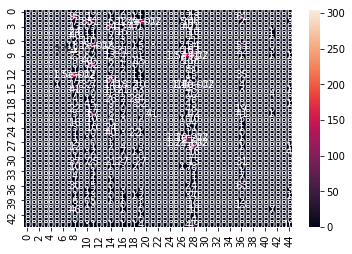

Epoch: 2  | time in 3 minutes, 21 seconds
	Loss: 0.1057(train)	|	Acc: 30.35%(train)
	Loss: 0.0019(valid)	|	Acc: 38.74%(valid)
	Kappa: 36.26%(valid)	|	f1-micro: 38.74%(valid)	|	f1-macro: 24.40%(valid)


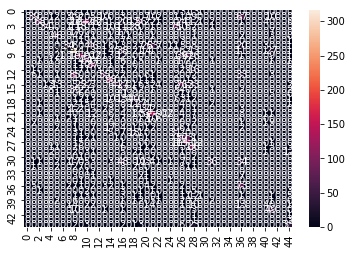

Epoch: 3  | time in 3 minutes, 26 seconds
	Loss: 0.0885(train)	|	Acc: 43.76%(train)
	Loss: 0.0017(valid)	|	Acc: 46.97%(valid)
	Kappa: 44.79%(valid)	|	f1-micro: 46.97%(valid)	|	f1-macro: 31.66%(valid)


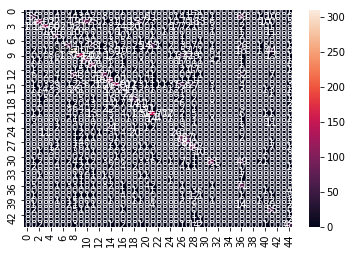

Epoch: 4  | time in 3 minutes, 31 seconds
	Loss: 0.0777(train)	|	Acc: 53.67%(train)
	Loss: 0.0015(valid)	|	Acc: 53.51%(valid)
	Kappa: 51.57%(valid)	|	f1-micro: 53.51%(valid)	|	f1-macro: 36.51%(valid)


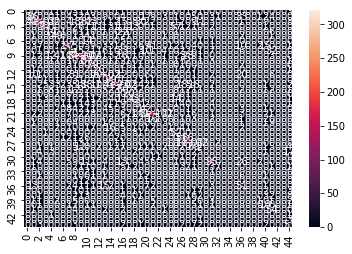

Epoch: 5  | time in 3 minutes, 31 seconds
	Loss: 0.0710(train)	|	Acc: 57.85%(train)
	Loss: 0.0014(valid)	|	Acc: 55.67%(valid)
	Kappa: 53.81%(valid)	|	f1-micro: 55.67%(valid)	|	f1-macro: 38.13%(valid)


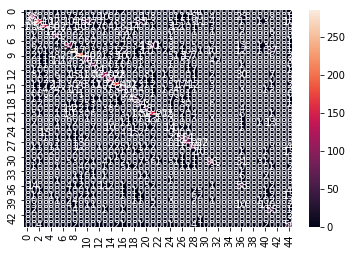

Epoch: 6  | time in 3 minutes, 33 seconds
	Loss: 0.0652(train)	|	Acc: 62.15%(train)
	Loss: 0.0013(valid)	|	Acc: 59.31%(valid)
	Kappa: 57.51%(valid)	|	f1-micro: 59.31%(valid)	|	f1-macro: 42.99%(valid)


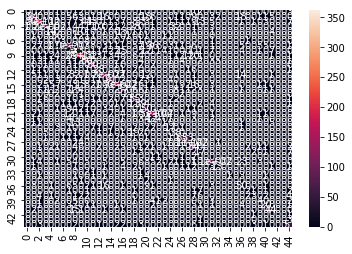

Epoch: 7  | time in 4 minutes, 55 seconds
	Loss: 0.0617(train)	|	Acc: 63.83%(train)
	Loss: 0.0015(valid)	|	Acc: 60.28%(valid)
	Kappa: 58.54%(valid)	|	f1-micro: 60.28%(valid)	|	f1-macro: 43.55%(valid)


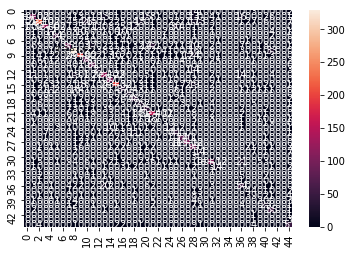

Epoch: 8  | time in 7 minutes, 42 seconds
	Loss: 0.0579(train)	|	Acc: 66.56%(train)
	Loss: 0.0012(valid)	|	Acc: 59.22%(valid)
	Kappa: 57.57%(valid)	|	f1-micro: 59.22%(valid)	|	f1-macro: 44.12%(valid)


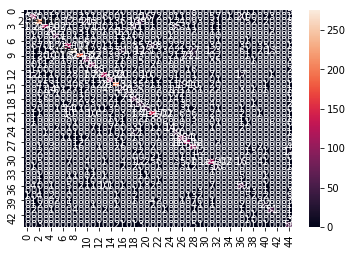

Epoch: 9  | time in 9 minutes, 19 seconds
	Loss: 0.0553(train)	|	Acc: 68.04%(train)
	Loss: 0.0014(valid)	|	Acc: 60.74%(valid)
	Kappa: 59.05%(valid)	|	f1-micro: 60.74%(valid)	|	f1-macro: 44.62%(valid)


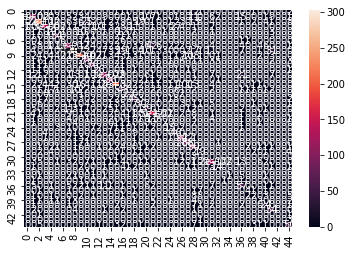

Epoch: 10  | time in 13 minutes, 11 seconds
	Loss: 0.0525(train)	|	Acc: 70.17%(train)
	Loss: 0.0013(valid)	|	Acc: 60.34%(valid)
	Kappa: 58.70%(valid)	|	f1-micro: 60.34%(valid)	|	f1-macro: 44.57%(valid)


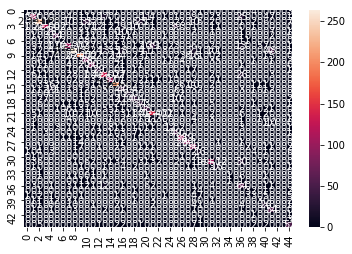

Epoch: 11  | time in 14 minutes, 20 seconds
	Loss: 0.0507(train)	|	Acc: 71.22%(train)
	Loss: 0.0014(valid)	|	Acc: 61.24%(valid)
	Kappa: 59.64%(valid)	|	f1-micro: 61.24%(valid)	|	f1-macro: 46.67%(valid)


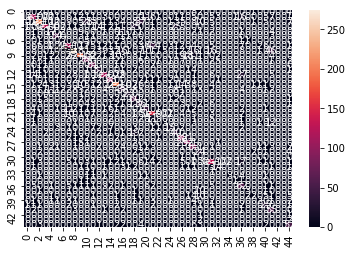

Epoch: 12  | time in 15 minutes, 57 seconds
	Loss: 0.0485(train)	|	Acc: 72.94%(train)
	Loss: 0.0012(valid)	|	Acc: 62.30%(valid)
	Kappa: 60.67%(valid)	|	f1-micro: 62.30%(valid)	|	f1-macro: 47.78%(valid)


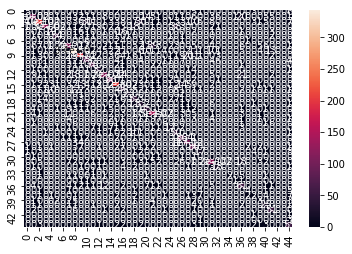

Epoch: 13  | time in 17 minutes, 0 seconds
	Loss: 0.0471(train)	|	Acc: 73.53%(train)
	Loss: 0.0014(valid)	|	Acc: 63.42%(valid)
	Kappa: 61.85%(valid)	|	f1-micro: 63.42%(valid)	|	f1-macro: 50.07%(valid)


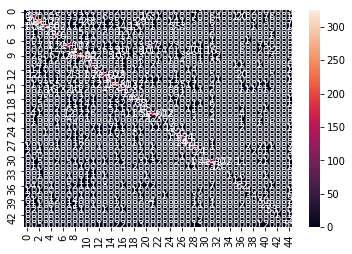

Epoch: 14  | time in 17 minutes, 42 seconds
	Loss: 0.0453(train)	|	Acc: 74.92%(train)
	Loss: 0.0012(valid)	|	Acc: 63.33%(valid)
	Kappa: 61.72%(valid)	|	f1-micro: 63.33%(valid)	|	f1-macro: 50.19%(valid)


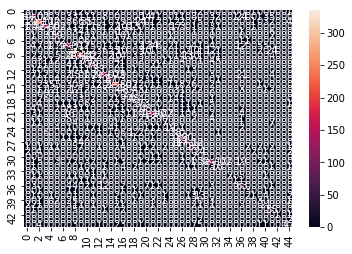

Epoch: 15  | time in 18 minutes, 21 seconds
	Loss: 0.0442(train)	|	Acc: 75.19%(train)
	Loss: 0.0014(valid)	|	Acc: 63.68%(valid)
	Kappa: 62.11%(valid)	|	f1-micro: 63.68%(valid)	|	f1-macro: 50.08%(valid)


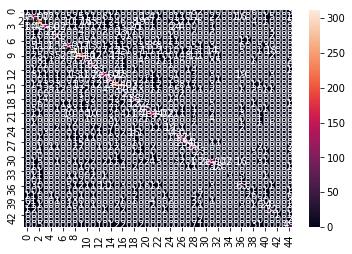

Epoch: 16  | time in 18 minutes, 42 seconds
	Loss: 0.0428(train)	|	Acc: 76.78%(train)
	Loss: 0.0012(valid)	|	Acc: 63.90%(valid)
	Kappa: 62.31%(valid)	|	f1-micro: 63.90%(valid)	|	f1-macro: 50.18%(valid)


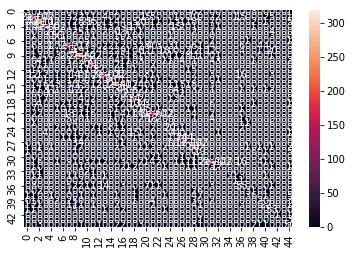

Epoch: 17  | time in 19 minutes, 17 seconds
	Loss: 0.0420(train)	|	Acc: 76.89%(train)
	Loss: 0.0013(valid)	|	Acc: 63.59%(valid)
	Kappa: 62.02%(valid)	|	f1-micro: 63.59%(valid)	|	f1-macro: 51.26%(valid)


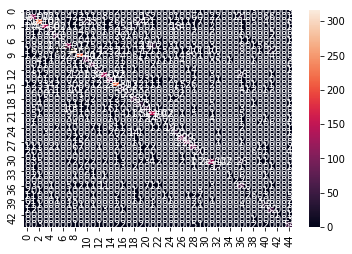

Epoch: 18  | time in 19 minutes, 44 seconds
	Loss: 0.0408(train)	|	Acc: 78.08%(train)
	Loss: 0.0012(valid)	|	Acc: 63.59%(valid)
	Kappa: 62.04%(valid)	|	f1-micro: 63.59%(valid)	|	f1-macro: 50.69%(valid)


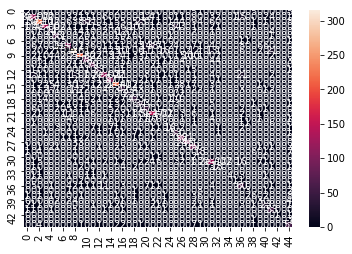

Epoch: 19  | time in 19 minutes, 41 seconds
	Loss: 0.0403(train)	|	Acc: 78.09%(train)
	Loss: 0.0012(valid)	|	Acc: 64.32%(valid)
	Kappa: 62.76%(valid)	|	f1-micro: 64.32%(valid)	|	f1-macro: 52.48%(valid)


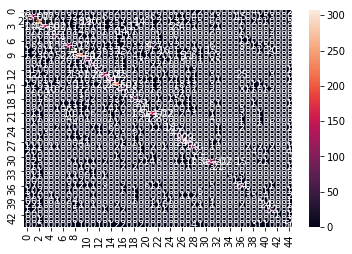

Epoch: 20  | time in 20 minutes, 7 seconds
	Loss: 0.0391(train)	|	Acc: 79.31%(train)
	Loss: 0.0011(valid)	|	Acc: 64.76%(valid)
	Kappa: 63.21%(valid)	|	f1-micro: 64.76%(valid)	|	f1-macro: 52.59%(valid)


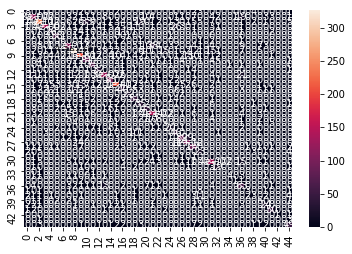

Epoch: 21  | time in 21 minutes, 13 seconds
	Loss: 0.0388(train)	|	Acc: 79.26%(train)
	Loss: 0.0012(valid)	|	Acc: 64.45%(valid)
	Kappa: 62.89%(valid)	|	f1-micro: 64.45%(valid)	|	f1-macro: 52.54%(valid)


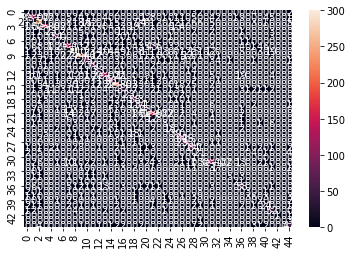

Epoch: 22  | time in 21 minutes, 41 seconds
	Loss: 0.0379(train)	|	Acc: 80.10%(train)
	Loss: 0.0011(valid)	|	Acc: 64.51%(valid)
	Kappa: 62.96%(valid)	|	f1-micro: 64.51%(valid)	|	f1-macro: 52.76%(valid)


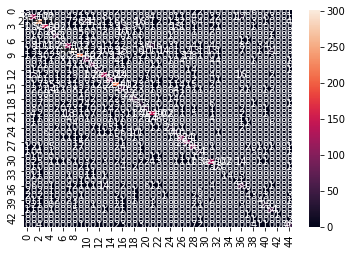

Epoch: 23  | time in 22 minutes, 18 seconds
	Loss: 0.0376(train)	|	Acc: 80.02%(train)
	Loss: 0.0012(valid)	|	Acc: 64.30%(valid)
	Kappa: 62.74%(valid)	|	f1-micro: 64.30%(valid)	|	f1-macro: 52.70%(valid)


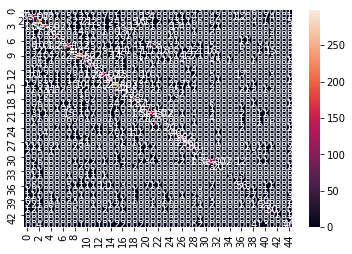

Epoch: 24  | time in 22 minutes, 32 seconds
	Loss: 0.0368(train)	|	Acc: 80.89%(train)
	Loss: 0.0012(valid)	|	Acc: 64.10%(valid)
	Kappa: 62.54%(valid)	|	f1-micro: 64.10%(valid)	|	f1-macro: 52.14%(valid)


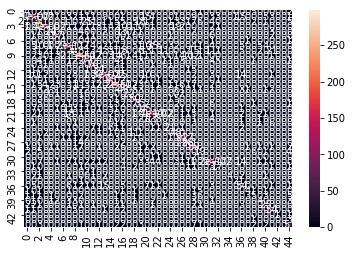

Epoch: 25  | time in 21 minutes, 55 seconds
	Loss: 0.0366(train)	|	Acc: 80.86%(train)
	Loss: 0.0012(valid)	|	Acc: 64.36%(valid)
	Kappa: 62.80%(valid)	|	f1-micro: 64.36%(valid)	|	f1-macro: 52.35%(valid)


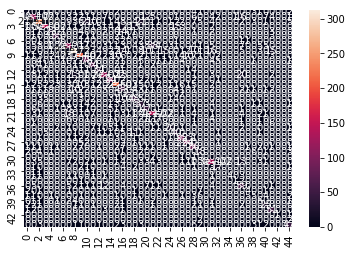

Epoch: 26  | time in 22 minutes, 2 seconds
	Loss: 0.0359(train)	|	Acc: 81.42%(train)
	Loss: 0.0011(valid)	|	Acc: 64.49%(valid)
	Kappa: 62.96%(valid)	|	f1-micro: 64.49%(valid)	|	f1-macro: 52.61%(valid)


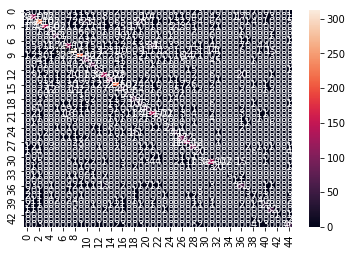

Epoch: 27  | time in 21 minutes, 40 seconds
	Loss: 0.0359(train)	|	Acc: 81.43%(train)
	Loss: 0.0012(valid)	|	Acc: 64.45%(valid)
	Kappa: 62.90%(valid)	|	f1-micro: 64.45%(valid)	|	f1-macro: 52.15%(valid)


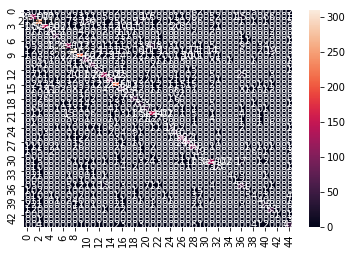

Epoch: 28  | time in 21 minutes, 33 seconds
	Loss: 0.0352(train)	|	Acc: 82.14%(train)
	Loss: 0.0011(valid)	|	Acc: 65.11%(valid)
	Kappa: 63.58%(valid)	|	f1-micro: 65.11%(valid)	|	f1-macro: 53.05%(valid)


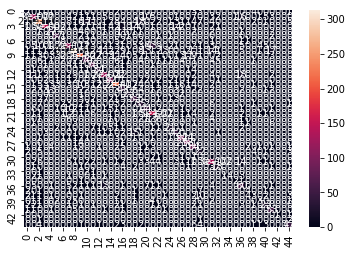

Epoch: 29  | time in 21 minutes, 37 seconds
	Loss: 0.0352(train)	|	Acc: 81.77%(train)
	Loss: 0.0013(valid)	|	Acc: 64.51%(valid)
	Kappa: 62.97%(valid)	|	f1-micro: 64.51%(valid)	|	f1-macro: 53.02%(valid)


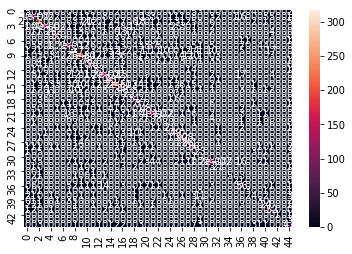

Epoch: 30  | time in 21 minutes, 56 seconds
	Loss: 0.0347(train)	|	Acc: 82.47%(train)
	Loss: 0.0011(valid)	|	Acc: 65.09%(valid)
	Kappa: 63.56%(valid)	|	f1-micro: 65.09%(valid)	|	f1-macro: 53.99%(valid)


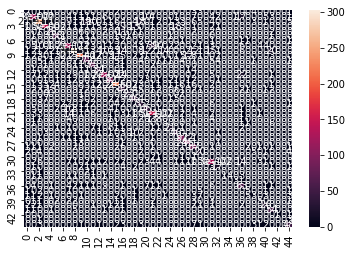

Epoch: 31  | time in 22 minutes, 13 seconds
	Loss: 0.0347(train)	|	Acc: 82.08%(train)
	Loss: 0.0013(valid)	|	Acc: 64.58%(valid)
	Kappa: 63.04%(valid)	|	f1-micro: 64.58%(valid)	|	f1-macro: 52.69%(valid)


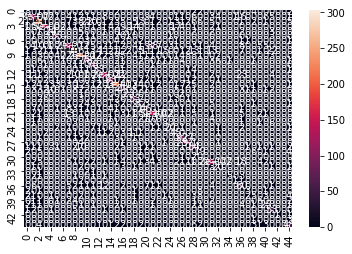

Epoch: 32  | time in 22 minutes, 12 seconds
	Loss: 0.0341(train)	|	Acc: 82.67%(train)
	Loss: 0.0012(valid)	|	Acc: 64.71%(valid)
	Kappa: 63.18%(valid)	|	f1-micro: 64.71%(valid)	|	f1-macro: 52.15%(valid)


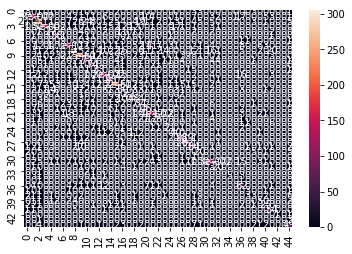

Epoch: 33  | time in 22 minutes, 44 seconds
	Loss: 0.0342(train)	|	Acc: 82.64%(train)
	Loss: 0.0013(valid)	|	Acc: 64.51%(valid)
	Kappa: 62.99%(valid)	|	f1-micro: 64.51%(valid)	|	f1-macro: 53.30%(valid)


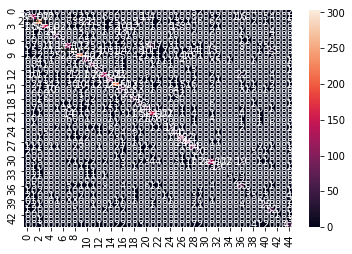

Epoch: 34  | time in 23 minutes, 0 seconds
	Loss: 0.0338(train)	|	Acc: 83.15%(train)
	Loss: 0.0012(valid)	|	Acc: 64.34%(valid)
	Kappa: 62.81%(valid)	|	f1-micro: 64.34%(valid)	|	f1-macro: 53.44%(valid)


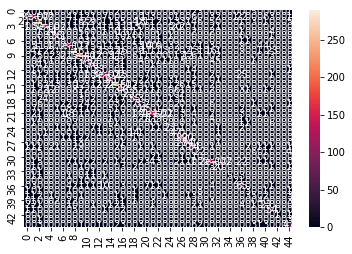

Epoch: 35  | time in 23 minutes, 39 seconds
	Loss: 0.0339(train)	|	Acc: 82.65%(train)
	Loss: 0.0013(valid)	|	Acc: 64.38%(valid)
	Kappa: 62.83%(valid)	|	f1-micro: 64.38%(valid)	|	f1-macro: 52.34%(valid)


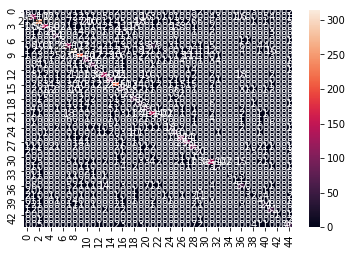

Epoch: 36  | time in 23 minutes, 35 seconds
	Loss: 0.0335(train)	|	Acc: 83.31%(train)
	Loss: 0.0012(valid)	|	Acc: 64.65%(valid)
	Kappa: 63.12%(valid)	|	f1-micro: 64.65%(valid)	|	f1-macro: 52.90%(valid)


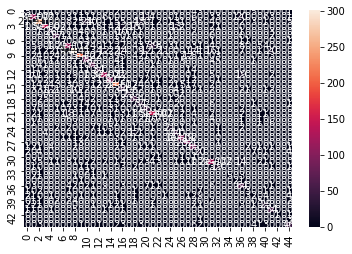

Epoch: 37  | time in 23 minutes, 43 seconds
	Loss: 0.0336(train)	|	Acc: 82.89%(train)
	Loss: 0.0013(valid)	|	Acc: 64.38%(valid)
	Kappa: 62.84%(valid)	|	f1-micro: 64.38%(valid)	|	f1-macro: 52.82%(valid)


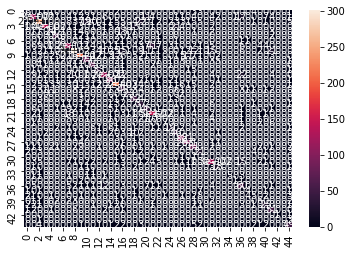

Epoch: 38  | time in 23 minutes, 52 seconds
	Loss: 0.0332(train)	|	Acc: 83.22%(train)
	Loss: 0.0012(valid)	|	Acc: 64.51%(valid)
	Kappa: 62.98%(valid)	|	f1-micro: 64.51%(valid)	|	f1-macro: 52.50%(valid)


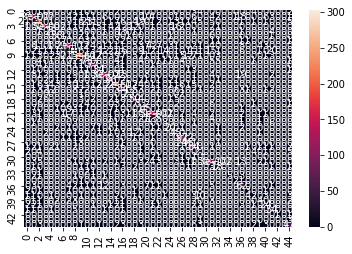

Epoch: 39  | time in 24 minutes, 44 seconds
	Loss: 0.0334(train)	|	Acc: 83.27%(train)
	Loss: 0.0012(valid)	|	Acc: 64.87%(valid)
	Kappa: 63.33%(valid)	|	f1-micro: 64.87%(valid)	|	f1-macro: 53.40%(valid)


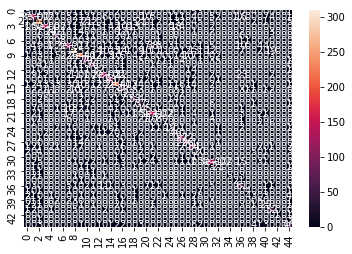

In [ ]:
## train the data
print('training begining...')
current_valid_acc= -100
for epoch in range(max_epoch):

    start_time = time.time()
    train_loss, train_acc = train_func(train_set)
    valid_loss, valid_acc, kappa, f1_micro,f1_macro,confusion = test_func(test_set)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.2f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.2f}%(valid)')
    print(f'\tKappa: {kappa*100:.2f}%(valid)\t|\tf1-micro: {f1_micro*100:.2f}%(valid)\t|\tf1-macro: {f1_macro * 100:.2f}%(valid)')
    sns.heatmap(confusion,annot=True)
    plt.show()
    if current_valid_acc<valid_acc:
        current_valid_acc=valid_acc
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': valid_loss,
        'acc': valid_acc,
         'Kappa':kappa,
        'f1-micro':f1_micro,
        'f1-macro':f1_macro,
        'confusion matrix':confusion
    }, 'Transformer_pure_model_0511_state_epoch_{}'.format(epoch))
    
    
    



In [ ]:
### Test- test

data = DataLoader(train_set, batch_size=1, shuffle=True,
                      collate_fn=generate_batch)

for i, (text, mask, seq_length_idx, label) in enumerate(data):
  print("i",type(i),i)
  print("text",type(text),text)
  print("mask",type(mask),mask)
  print("seq_length_idx",type(seq_length_idx),seq_length_idx)
  print("label",type(label),label)
  break

torch.addmm(input, mat1, mat2, *, beta=1, alpha=1, out=None) → Tensor

In [ ]:
confusion


NameError: ignored

In [ ]:
conf_mat_norm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

In [ ]:
conf_mat_norm

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)

confusion

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize = (60,60))
classes = range(1,47)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('guess')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
 
plt.show()


In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize = (15,15))
classes = range(1,300)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('guess')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
 
plt.show()


In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
classes = range(1,47)
plt.imshow(conf_mat_norm, cmap=plt.cm.Blues)
indices = range(len(conf_mat_norm))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('guess')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
 
plt.show()
